In [1]:
import psycopg2
import pandas as pd
import numpy as np
import nltk
import re
import sklearn
import spacy
import gensim 
import warnings
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from numpy import asarray
from numpy import zeros
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

Using TensorFlow backend.


Executive Summary:

# I. Load Data

In [2]:
conn = psycopg2.connect(database="threadtogether", user="dso_student", password="-H4jgA`rn6w`=Jg(", host="threadtogether.ychennay.com", port="5432")

In [3]:
# View all the tables
cur = conn.cursor()
cur.execute("""select *  
                            from information_schema.tables
                            where table_schema='public'""")
data = cur.fetchall()

In [4]:
pd.DataFrame(data, columns=[desc[0] for desc in cur.description])

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,threadtogether,public,full_data,BASE TABLE,None,None,None,None,None,YES,NO,None
1,threadtogether,public,womens_clothing_reviews,BASE TABLE,None,None,None,None,None,YES,NO,None
2,threadtogether,public,tagged_product_attributes,BASE TABLE,None,None,None,None,None,YES,NO,None
3,threadtogether,public,categories,BASE TABLE,None,None,None,None,None,YES,NO,None
4,threadtogether,public,outfits,BASE TABLE,None,None,None,None,None,YES,NO,None
5,threadtogether,public,outfit_combinations,VIEW,None,None,None,None,None,NO,NO,None


In [5]:
# Extract data from full_data
cur = conn.cursor()
cur.execute("select *  from full_data")
data = cur.fetchall()

In [6]:
full_data = pd.DataFrame(data, columns=[desc[0] for desc in cur.description])
full_data.head()

,product_id,brand,mpn,product_full_name,description,brand_category,created_at,updated_at,deleted_at,brand_canonical_url,details,labels,bc_product_id
0,01DSE9TC2DQXDG6GWKW9NMJ416,Banana Republic,514683,Ankle-Strap Pump,"A modern pump, in a rounded silhouette with an...",Unknown,2019-11-11 22:37:15.719107+00,2019-12-19 20:40:30.786144+00,NULL,https://bananarepublic.gap.com/browse/product....,"A modern pump, in a rounded silhouette with an...","{""Needs Review""}",NULL
1,01DSE9SKM19XNA6SJP36JZC065,Banana Republic,526676,Petite Tie-Neck Top,Dress it down with jeans and sneakers or dress...,Unknown,2019-11-11 22:36:50.682513+00,2019-12-19 20:40:30.786144+00,NULL,https://bananarepublic.gap.com/browse/product....,Dress it down with jeans and sneakers or dress...,"{""Needs Review""}",NULL
2,01DSJX8GD4DSAP76SPR85HRCMN,Loewe,4.001E+11,52MM Padded Leather Round Sunglasses,Padded leather covers classic round sunglasses.,JewelryAccessories/SunglassesReaders/RoundOval...,2019-11-13 17:33:59.581661+00,2019-12-19 20:40:30.786144+00,NULL,https://www.saksfifthavenue.com/loewe-52mm-pad...,100% UV protection\nCase and cleaning cloth in...,"{""Needs Review""}",NULL
3,01DSJVKJNS6F4KQ1QM6YYK9AW2,Converse,4.00012E+11,Baby's & Little Kid's All-Star Two-Tone Mid-To...,The iconic mid-top design gets an added dose o...,"JustKids/Shoes/Baby024Months/BabyGirl,JustKids...",2019-11-13 17:05:05.203733+00,2019-12-19 20:40:30.786144+00,NULL,https://www.saksfifthavenue.com/converse-babys...,Canvas upper\nRound toe\nLace-up vamp\nSmartFO...,"{""Needs Review""}",NULL
4,01DSK15ZD4D5A0QXA8NSD25YXE,Alexander McQueen,4.00011E+11,64MM Rimless Sunglasses,Hexagonal shades offer a rimless view with int...,JewelryAccessories/SunglassesReaders/RoundOval,2019-11-13 18:42:30.941321+00,2019-12-19 20:40:30.786144+00,NULL,https://www.saksfifthavenue.com/alexander-mcqu...,100% UV protection\nGradient lenses\nAdjustabl...,"{""Needs Review""}",NULL


In [7]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48979 entries, 0 to 48978
Data columns (total 13 columns):
product_id             48979 non-null object
brand                  48979 non-null object
mpn                    48979 non-null object
product_full_name      48979 non-null object
description            41005 non-null object
brand_category         48741 non-null object
created_at             48979 non-null object
updated_at             48979 non-null object
deleted_at             45984 non-null object
brand_canonical_url    48967 non-null object
details                47950 non-null object
labels                 48979 non-null object
bc_product_id          48979 non-null object
dtypes: object(13)
memory usage: 4.9+ MB


In [8]:
# Extract data from tagged_product_attributes
cur = conn.cursor()
cur.execute("select *  from tagged_product_attributes")
data = cur.fetchall()

In [9]:
tagged_data = pd.DataFrame(data, columns=[desc[0] for desc in cur.description])
tagged_data.head()

,product_id,product_color_id,attribute_name,attribute_value,file
0,01DVBTBPHR8WJTCVEN5AJRHF47,01DVBTBPJ41VVT00JJCG8TTZ2W,gender,Women,initial_tags
1,01DVA7QRXM928ZM0WWR7HFNTC1,01DVA7QRXXR9F0TWVE1HMC5ZQ3,Primary Color,Blacks,initial_tags
2,01DPGV4YRP3Z8J85DASGZ1Y99W,01DPGVGBK6YGNYGNF2S6FSH02T,style,Casual,initial_tags
3,01E1JM43NQ3H17PB22EV3074NX,01E1JM5WFWWCCCH3JTTTCYQCEQ,style,Modern,initial_tags
4,01DSE8Z2ZDAZKZ2SKCS1E3B3HK,01DSE8ZG8Y3FR8KWE2TY1QDWBF,shoe_width,Medium,initial_tags


In [10]:
tagged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119345 entries, 0 to 119344
Data columns (total 5 columns):
product_id          119345 non-null object
product_color_id    119345 non-null object
attribute_name      119345 non-null object
attribute_value     119345 non-null object
file                119345 non-null object
dtypes: object(5)
memory usage: 4.6+ MB


In [11]:
# Extract data from womens_clothing_reviews
cur = conn.cursor()
cur.execute("select *  from womens_clothing_reviews")
data = cur.fetchall()

In [12]:
reviews = pd.DataFrame(data, columns=[desc[0] for desc in cur.description])
reviews.head()

,clothing_id,age,title,review_text,rating,recommend,likes,division,department,class
0,767,33,None,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,None,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [13]:
# Extract data from categories
cur = conn.cursor()
cur.execute("select *  from categories")
data = cur.fetchall()

In [14]:
# View
pd.DataFrame(data, columns=[desc[0] for desc in cur.description]).head()

,value,category,type,quantifier
0,Androgynous,style,general,many
1,Athleisure,style,general,many
2,Boho,style,general,many
3,Business Casual,style,general,many
4,Casual,style,general,many


In [15]:
# Extract data from outfits
cur = conn.cursor()
cur.execute("select *  from outfits")
data = cur.fetchall()

In [16]:
# View
pd.DataFrame(data, columns=[desc[0] for desc in cur.description]).head()

,outfit_id,product_color_id,outfit_item_type
0,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA2S83FARJW4QWRBXNS,shoe
1,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA2V2Y8EN8YPY1E16EV,accessory1
2,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA23E5A8GBES8QJN3HF,top
3,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA2C7BQN0X7MNNYXBHW,bottom
4,01DMHCX50CFX5YNG99F3Y65GQW,01DMBRYVA2S83FARJW4QWRBXNS,shoe


In [17]:
outfit = pd.DataFrame(data, columns=[desc[0] for desc in cur.description])

In [18]:
np.unique(outfit['outfit_item_type'])

array(['accessory1', 'accessory2', 'accessory3', 'bottom', 'onepiece',
       'shoe', 'top'], dtype=object)

# II. Text Preprocessing

In [19]:
# join full_data and tagged_data. Replace NAs and \n
join_data = full_data.merge(tagged_data, on='product_id')
join_data = join_data.replace(np.nan, "", regex=True)
join_data = join_data.replace("\n", "",regex=True)
join_data['attribute_value'].replace(r'\bbusinesscasual\b', 'business casual', inplace=True, regex=True)
join_data.head(3)

,product_id,brand,mpn,product_full_name,description,brand_category,created_at,updated_at,deleted_at,brand_canonical_url,details,labels,bc_product_id,product_color_id,attribute_name,attribute_value,file
0,01E5ZXP5H0BTEZT9QD2HRZJ47A,A.L.C.,5529544,Lennox High Waist Cotton & Linen Pants,High-rise trousers tailored from a cool Italia...,Unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"True to size. High rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,linenblend,additional
1,01E5ZXP5H0BTEZT9QD2HRZJ47A,A.L.C.,5529544,Lennox High Waist Cotton & Linen Pants,High-rise trousers tailored from a cool Italia...,Unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"True to size. High rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,cottonblend,additional
2,01E5ZXP5H0BTEZT9QD2HRZJ47A,A.L.C.,5529544,Lennox High Waist Cotton & Linen Pants,High-rise trousers tailored from a cool Italia...,Unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"True to size. High rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,style,modern,additional


In [20]:
# Lower case some target texts
columns_list = ['brand','product_full_name','description','brand_category','details',
                'attribute_name','attribute_value']
for column in columns_list:
    join_data[column] = join_data[column].str.lower()
join_data.head(3)

,product_id,brand,mpn,product_full_name,description,brand_category,created_at,updated_at,deleted_at,brand_canonical_url,details,labels,bc_product_id,product_color_id,attribute_name,attribute_value,file
0,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c.,5529544,lennox high waist cotton & linen pants,high-rise trousers tailored from a cool italia...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"true to size. high rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,linenblend,additional
1,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c.,5529544,lennox high waist cotton & linen pants,high-rise trousers tailored from a cool italia...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"true to size. high rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,cottonblend,additional
2,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c.,5529544,lennox high waist cotton & linen pants,high-rise trousers tailored from a cool italia...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,"true to size. high rise.31"" inseam; 14"" leg op...",[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,style,modern,additional


In [21]:
# Remove stopwords
from nltk.corpus import stopwords
from nltk import word_tokenize

columns_list2 = ['brand','product_full_name','description','brand_category','details']
nltk_stopwords = set(stopwords.words('english') + [".",",",":","''","'s","'","``","(", ")","]",
                                                   "-","!","/",">","<",";","#","...","..","?","--","[","&"])
for column in columns_list2:
    join_data[column] = join_data[column].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in nltk_stopwords]))
    
join_data.head(3)

,product_id,brand,mpn,product_full_name,description,brand_category,created_at,updated_at,deleted_at,brand_canonical_url,details,labels,bc_product_id,product_color_id,attribute_name,attribute_value,file
0,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c,5529544,lennox high waist cotton linen pants,high-rise trousers tailored cool italian cotto...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,true size high rise.31 inseam 14 leg opening 1...,[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,linenblend,additional
1,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c,5529544,lennox high waist cotton linen pants,high-rise trousers tailored cool italian cotto...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,true size high rise.31 inseam 14 leg opening 1...,[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,cottonblend,additional
2,01E5ZXP5H0BTEZT9QD2HRZJ47A,a.l.c,5529544,lennox high waist cotton linen pants,high-rise trousers tailored cool italian cotto...,unknown,2020-04-15 21:59:56.695000+00:00,2020-04-17 15:44:57.785000+00:00,2020-04-17 15:44:57.785000+00:00,https://shop.nordstrom.com/s/a-l-c-lennox-high...,true size high rise.31 inseam 14 leg opening 1...,[],5021,01E5ZXP5JCREDC7WJVMWHK5Q40,style,modern,additional


In [22]:
# Lemmatization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

for column in columns_list2:
    join_data[column] = join_data[column].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

# III. Modelling

In [23]:
# Michael's way of finding input texts you need (for reference) 
join_data['tag_info'] = join_data[['brand','product_full_name','brand_category','details','description']].apply(lambda x: ' '.join(x), axis=1)
join_data['tag_info'][0]

'a.l.c lennox high waist cotton linen pant unknown true size high rise.31 inseam 14 leg opening 12 front rise 15 1/2 back rise size 8 zip fly hook-and-bar closurefront slant pocket back welt pockets67 % cotton 33 % linendry cleanimportedvia c high-rise trouser tailored cool italian cotton-and-linen blend make refreshing addition work wardrobe'

In [24]:
Style = join_data[join_data['attribute_name']=='style'][['tag_info', 'attribute_value']]
Style.shape

(25539, 2)

In [25]:
Style = join_data[join_data['attribute_name']=='style'][['tag_info', 'attribute_value']].drop_duplicates()
Style.shape

(10971, 2)

In [26]:
stylelist = list(np.unique(Style['attribute_value']))

In [27]:
Style.reset_index(drop=True, inplace=True)

## LSTM for all styles

In [28]:
# Prepare data
for sty in np.unique(Style['attribute_value']):
    Style[sty] = 0
    Style[sty][Style['attribute_value']==sty]=1
Style.head(10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,tag_info,attribute_value,androgynous,athleisure,boho,business casual,casual,classic,edgy,glam,modern,retro,romantic
0,a.l.c lennox high waist cotton linen pant unkn...,modern,0,0,0,0,0,0,0,0,1,0,0
1,a.l.c lennox high waist cotton linen pant unkn...,business casual,0,0,0,1,0,0,0,0,0,0,0
2,a.l.c lennox high waist cotton linen pant unkn...,classic,0,0,0,0,0,1,0,0,0,0,0
3,banana republic mock-neck sweater top unknown ...,classic,0,0,0,0,0,1,0,0,0,0,0
4,banana republic mock-neck sweater top unknown ...,business casual,0,0,0,1,0,0,0,0,0,0,0
5,simon miller rost belted short unknown true si...,modern,0,0,0,0,0,0,0,0,1,0,0
6,simon miller rost belted short unknown true si...,casual,0,0,0,0,1,0,0,0,0,0,0
7,simon miller rost belted short unknown true si...,androgynous,1,0,0,0,0,0,0,0,0,0,0
8,a.l.c minelli silk sleeveless top unknown true...,modern,0,0,0,0,0,0,0,0,1,0,0
9,a.l.c minelli silk sleeveless top unknown true...,boho,0,0,1,0,0,0,0,0,0,0,0


In [34]:
# Import tools for tokenizaton and encoding
from keras.preprocessing.text import Tokenizer
from typing import List
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Import Keras Toolkit
from random import randint
from numpy import array, argmax, asarray, zeros
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers.recurrent import  LSTM
from keras.layers import Flatten, Masking

# Define integer encoder for documents
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

# Define max length detection tool
def get_max_token_length_per_doc(docs: List[List[str]])-> int:
    return max(list(map(lambda x: len(x.split()), docs)))

# Load in GloVe Vectors
def load_glove_vectors():
    embeddings_index = {}
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index

embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


In [31]:
# import K-Fold validation
from sklearn.model_selection import KFold

In [61]:
stylelist

['androgynous',
 'athleisure',
 'boho',
 'business casual',
 'casual',
 'classic',
 'edgy',
 'glam',
 'modern',
 'retro',
 'romantic']

In [62]:
stylelist[0:2]

['androgynous', 'athleisure']

Due to the randomness of neural network, we set 3 loops (limited time & resources) to average all the metrics, and within each loop, 10-fold cross-validation is applied. Therefore, totally 3 * 10 = 30 loops for each style to achieve relatively lower variance.

In [60]:
warnings.filterwarnings("ignore")
for style in stylelist[0:2]:
    
    print(style,'=========================================')
    
    acclist = []
    precisionlist = []
    recalllist = []
    auclist = []

    data = Style.groupby('tag_info').agg(specific_style = pd.NamedAgg(column=style, aggfunc='max')).reset_index()
    data1 = data[data['specific_style']==1]
    data2 = data[data['specific_style']==0].sample(round(len(data1)*1.7), random_state=123)
    data = pd.concat([data1, data2])
    tag_list = list(data['tag_info'])

    # Tokenize the Text
    tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
    tokenizer.fit_on_texts(tag_list)

    # get the max length in terms of token length
    max_length = get_max_token_length_per_doc(tag_list)

    # integer encode the documents
    encoded_docs = integer_encode_documents(tag_list, tokenizer)
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

    encoder = LabelEncoder()
    labels = data['specific_style']
    labels = to_categorical(encoder.fit_transform(labels))

    X_train = padded_docs
    y_train = labels
    
    VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

    # Load in Embeddings
    # create a weight matrix for words in training docs
    embedding_matrix = zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: # check that it is an actual word that we have embeddings for
            embedding_matrix[i] = embedding_vector

    def make_lstm_classification_model(plot=False):
        model = Sequential()
        model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
        model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
        model.add(LSTM(units=32, input_shape=(1, max_length)))
        # model.add(Dense(16))
        model.add(Dense(8))
        model.add(Dense(2, activation='sigmoid'))

        # Compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


        if plot:
            plot_model(model, to_file='model.png', show_shapes=True)
        return model
    
    for loop in range(3):
        
        model = make_lstm_classification_model()
        
        # k-fold cross validation
        kfold = KFold(n_splits=10, shuffle=True)
        # enumerate splits
        for train_index, test_index in kfold.split(X_train):
            # split train & test
            cross_train_X, cross_test_X = X_train[train_index], X_train[test_index]
            cross_train_y, cross_test_y = y_train[train_index], y_train[test_index]
            # fit model
            model = make_lstm_classification_model()
            model.fit(cross_train_X, cross_train_y, epochs=15, verbose=0)
            # evaluate model
            y_prob = model.predict(cross_test_X) 
            y_classes = y_prob.argmax(axis=-1)
            ytest = [np.argmax(y, axis=None, out=None) for y in cross_test_y]
            # acc
            acc = sklearn.metrics.accuracy_score(ytest, y_classes)
            # precision 
            precision = sklearn.metrics.precision_score(ytest, y_classes)
            # recall
            recall = sklearn.metrics.recall_score(ytest, y_classes)
            # auc
            auc = sklearn.metrics.roc_auc_score(ytest, [y[1] for y in y_prob])

            acclist.append(acc)
            precisionlist.append(precision)
            recalllist.append(recall)
            auclist.append(auc)

    print('accuracy: %f' % np.mean(acclist))
    print('precision: %f' % np.mean(precisionlist))
    print('recall: %f' % np.mean(recalllist))
    print('AUROC: %f' % np.mean(auclist))

androgynous =========================================
accuracy: 0.737565
precision: 0.665991
recall: 0.592313
AUROC: 0.781542
accuracy: 0.742587
precision: 0.661438
recall: 0.638343
AUROC: 0.794558


KeyboardInterrupt: 

## LSTM for all occasions

## LSTM for all categories

For categories, we use LSTM and softmax at the output layer for multiple classification

In [24]:
Category = join_data[join_data["attribute_name"] == 'category'][['tag_info', 'attribute_value']].reset_index(drop = 1)
Category.head()

,tag_info,attribute_value
0,a.l.c lennox high waist cotton linen pant unkn...,bottom
1,banana republic mock-neck sweater top unknown ...,top
2,banana republic mock-neck sweater top unknown ...,top
3,banana republic mock-neck sweater top unknown ...,top
4,banana republic mock-neck sweater top unknown ...,top


In [27]:
# the  data dictionary shows there are six categories in total
cur = conn.cursor()
cur.execute("select *  from categories")
data = cur.fetchall()
category = pd.DataFrame(data, columns=[desc[0] for desc in cur.description])
category[category["category"] == "category" ]

,value,category,type,quantifier
64,Top,category,general,one
65,Bottom,category,general,one
66,One Piece,category,general,one
67,Shoe,category,general,one
68,Handbag,category,general,one
69,Scarf,category,general,one


In [28]:
# but actually there are 11 tags 
set(Category.attribute_value)

{'accessory',
 'blazers, coats & jackets',
 'blazerscoatsjackets',
 'bottom',
 'one piece',
 'onepiece',
 'shoe',
 'sweater',
 'sweatshirt & hoodie',
 'sweatshirthoodie',
 'top'}

In [29]:
# we merged three categories with their synonym and turn 11 categories into 8
Category.loc[Category['attribute_value'] ==   'blazerscoatsjackets', 'attribute_value'] =  'blazers, coats & jackets'
Category.loc[Category['attribute_value'] ==   'onepiece', 'attribute_value'] = 'one piece'
Category.loc[Category['attribute_value'] ==   'sweatshirthoodie', 'attribute_value'] =  'sweatshirt & hoodie'
set(Category.attribute_value)

{'accessory',
 'blazers, coats & jackets',
 'bottom',
 'one piece',
 'shoe',
 'sweater',
 'sweatshirt & hoodie',
 'top'}

In [30]:
# their distribution is as follows:
Category.groupby('attribute_value').agg('count')

,tag_info
attribute_value,
accessory,878
"blazers, coats & jackets",614
bottom,1820
one piece,871
shoe,1868
sweater,737
sweatshirt & hoodie,235
top,1992


In [50]:
# use the same LSTM model, the only difference is multiple classification at the output layer 
stopwords_removed_docs = list(Category['tag_info'])
max_length = get_max_token_length_per_doc(stopwords_removed_docs)

tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(stopwords_removed_docs)

# integer encode the documents
encoded_docs = integer_encode_documents(stopwords_removed_docs, tokenizer)
# this is a list of lists, the numbers represent the index position of that word.
# for instance, 33 means the 33rd word in the vocabulary
# Notice the last document has 4 numbers, since it is a 4 word document: Could have done better.
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

encoder = LabelEncoder()
labels = Category.attribute_value
labels = to_categorical(encoder.fit_transform(labels))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.1, random_state=23)

VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

# create a weight matrix for words in training docs
embedding_matrix = zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

In [43]:
# define the model
def make_lstm_classification_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=32, input_shape=(1, max_length)))
    model.add(Dense(16))
    model.add(Dense(8, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [44]:
# compile the model
model = make_lstm_classification_model()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 187, 100)          1035300   
_________________________________________________________________
masking_1 (Masking)          (None, 187, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
Total params: 1,052,988
Trainable params: 17,688
Non-trainable params: 1,035,300
_________________________________________________________________


In [45]:
# fit the model
history = model.fit(X_train, y_train,validation_split = 0.1, epochs=10, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 7301 samples, validate on 812 samples
Epoch 1/10
7301/7301 [==============================] - 38s 5ms/step - loss: 1.4397 - acc: 0.4668 - val_loss: 0.8990 - val_acc: 0.6860
Epoch 2/10
7301/7301 [==============================] - 36s 5ms/step - loss: 0.6433 - acc: 0.7872 - val_loss: 0.4506 - val_acc: 0.8559
Epoch 3/10
7301/7301 [==============================] - 34s 5ms/step - loss: 0.3229 - acc: 0.9040 - val_loss: 0.2715 - val_acc: 0.9187
Epoch 4/10
7301/7301 [==============================] - 37s 5ms/step - loss: 0.1769 - acc: 0.9519 - val_loss: 0.1965 - val_acc: 0.9421
Epoch 5/10
7301/7301 [==============================] - 37s 5ms/step - loss: 0.1226 - acc: 0.9677 - val_loss: 0.1571 - val_acc: 0.9569
Epoch 6/10
7301/7301 [==============================] - 36s 5ms/step - loss: 0.0827 - acc: 0.9797 - val_loss: 0.1448 - val_acc: 0.9606
Epoch 7/10
7301/7301 [==============================] - 36s 5ms/step - loss: 0.0661 - acc: 0.98

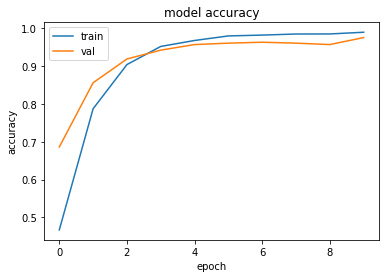

In [48]:
# plot the results
from matplotlib import pyplot as plt

def plot_fit_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot_fit_history(history)

In [49]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

902/902 [==============================] - 1s 1ms/step
Accuracy: 98.558758


# IV. Appendix

## The process we explored LSTM algorithm - take 'androgynous' as example

In [35]:
for sty in np.unique(Style['attribute_value']):
    Style[sty] = 0
    Style[sty][Style['attribute_value']==sty]=1

In [36]:
Style.head(10)

,tag_info,attribute_value,androgynous,athleisure,boho,business casual,casual,classic,edgy,glam,modern,retro,romantic
0,a.l.c lennox high waist cotton linen pant unkn...,modern,0,0,0,0,0,0,0,0,1,0,0
1,a.l.c lennox high waist cotton linen pant unkn...,business casual,0,0,0,1,0,0,0,0,0,0,0
2,a.l.c lennox high waist cotton linen pant unkn...,classic,0,0,0,0,0,1,0,0,0,0,0
3,banana republic mock-neck sweater top unknown ...,classic,0,0,0,0,0,1,0,0,0,0,0
4,banana republic mock-neck sweater top unknown ...,business casual,0,0,0,1,0,0,0,0,0,0,0
5,simon miller rost belted short unknown true si...,modern,0,0,0,0,0,0,0,0,1,0,0
6,simon miller rost belted short unknown true si...,casual,0,0,0,0,1,0,0,0,0,0,0
7,simon miller rost belted short unknown true si...,androgynous,1,0,0,0,0,0,0,0,0,0,0
8,a.l.c minelli silk sleeveless top unknown true...,modern,0,0,0,0,0,0,0,0,1,0,0
9,a.l.c minelli silk sleeveless top unknown true...,boho,0,0,1,0,0,0,0,0,0,0,0


In [37]:
# Try androgynous
androgynous_data = Style.groupby('tag_info').agg(androgynous = pd.NamedAgg(column='androgynous', aggfunc='max')).reset_index()

In [38]:
androgynous_data.head(5)

,tag_info,androgynous
0,360 cashmere ella plaid crop sweater womensapp...,1
1,7 mankind cowl satin tank top womensapparel/to...,0
2,7 mankind® 7 mankind high waist skinny jean un...,0
3,7 mankind® 7 mankind modern dojo wide leg jean...,0
4,7 mankind® alexa crop wide leg high waist jean...,0


In [39]:
androgynous_data1 = androgynous_data[androgynous_data['androgynous']==1]

In [40]:
androgynous_data2 = androgynous_data[androgynous_data['androgynous']==0].sample(round(len(androgynous_data1)*1.5), random_state=123)

In [41]:
androgynous_data = pd.concat([androgynous_data1, androgynous_data2])

In [42]:
tag_list = list(androgynous_data['tag_info'])

In [43]:
# Tokenize the Text
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(tag_list)

In [44]:
# Integer Encode Tokens
from typing import List
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

# Get Max Length Per Token
def get_max_token_length_per_doc(docs: List[List[str]])-> int:
    return max(list(map(lambda x: len(x.split()), docs)))

# get the max length in terms of token length
max_length = get_max_token_length_per_doc(tag_list)

print(max_length)

143


In [45]:
# integer encode the documents
encoded_docs = integer_encode_documents(tag_list, tokenizer)
# this is a list of lists, the numbers represent the index position of that word.
# for instance, 33 means the 33rd word in the vocabulary
# Notice the last document has 4 numbers, since it is a 4 word document: Could have done better.
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [46]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = androgynous_data['androgynous']
labels = to_categorical(encoder.fit_transform(labels))

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.1, random_state=23)

In [48]:
# Import Keras Toolkit
from random import randint
from numpy import array, argmax, asarray, zeros
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding

In [49]:
VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

In [50]:
# Load in GloVe Vectors
def load_glove_vectors():
    embeddings_index = {}
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index

embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


In [51]:
# Load in Embeddings
# create a weight matrix for words in training docs
embedding_matrix = zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

In [52]:
# Define in Model

from keras.layers.recurrent import  LSTM
from keras.layers import Flatten, Masking
# define model

def make_lstm_classification_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=32, input_shape=(1, max_length)))
    # model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(2, activation='sigmoid'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

## Compile Model

#### Helpful Rule of Thumb for Defining # of Parameters in LSTM:

$$
W = 4d×(n+d)
$$
Where $d$ is the number of memory cells, and $N$ is the number of dimensions for a data point.

In [53]:
model = make_lstm_classification_model()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 143, 100)          735600    
_________________________________________________________________
masking_29 (Masking)         (None, 143, 100)          0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dense_57 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_58 (Dense)             (None, 2)                 18        
Total params: 752,906
Trainable params: 17,306
Non-trainable params: 735,600
_________________________________________________________________


## Fit the Model

In [54]:
# fit the model
history = model.fit(X_train, y_train,validation_split = 0.1, epochs=15, verbose=1)

Train on 1494 samples, validate on 166 samples
Epoch 1/15
1494/1494 [==============================] - 6s 4ms/step - loss: 0.6672 - accuracy: 0.6145 - val_loss: 0.6820 - val_accuracy: 0.5542
Epoch 2/15
1494/1494 [==============================] - 4s 3ms/step - loss: 0.6447 - accuracy: 0.6379 - val_loss: 0.6571 - val_accuracy: 0.5904s: 0
Epoch 3/15
1494/1494 [==============================] - 4s 3ms/step - loss: 0.6131 - accuracy: 0.6513 - val_loss: 0.5832 - val_accuracy: 0.6747
Epoch 4/15
1494/1494 [==============================] - 4s 3ms/step - loss: 0.5749 - accuracy: 0.6834 - val_loss: 0.5473 - val_accuracy: 0.6867
Epoch 5/15
1494/1494 [==============================] - 4s 3ms/step - loss: 0.5320 - accuracy: 0.7383 - val_loss: 0.4825 - val_accuracy: 0.7711
Epoch 6/15
1494/1494 [==============================] - 4s 3ms/step - loss: 0.5060 - accuracy: 0.7510 - val_loss: 0.5113 - val_accuracy: 0.7831
Epoch 7/15
1494/1494 [==============================] - 4s 3ms/step - loss: 0.4739 - 

In [47]:
import keras
from matplotlib import pyplot as plt

def plot_fit_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot_fit_history(history)

KeyError: 'accuracy'

In [56]:
1-np.mean(androgynous_data['androgynous'])

0.6

In [57]:
y_prob = model.predict(X_test) 
y_classes = y_prob.argmax(axis=-1)
ytest = [np.argmax(y, axis=None, out=None) for y in y_test]

In [58]:
import sklearn
print('confusion_matrix ', sklearn.metrics.confusion_matrix(ytest, y_classes))
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(ytest, y_classes).ravel()
print('tn, fp, fn, tp: ', (tn, fp, fn, tp))
# acc
print('accuracy: ', sklearn.metrics. accuracy_score(ytest, y_classes))
# precision 
print('precision: ', sklearn.metrics.precision_score(ytest, y_classes))
# recall
print('recall', sklearn.metrics.recall_score(ytest, y_classes))
# auc
print('AUROC: ', sklearn.metrics.roc_auc_score(ytest, [y[1] for y in y_prob]))

confusion_matrix  [[80 32]
 [18 55]]
tn, fp, fn, tp:  (80, 32, 18, 55)
accuracy:  0.7297297297297297
precision:  0.632183908045977
recall 0.7534246575342466
AUROC:  0.8021037181996086


### Some of the parameter tuning, due to limit of time & resource, we could only do very small part of the whole project's algorithms. To keep the whole notebook neat and clean, we only show some of the results here:

**Different number of nodes on dense layer, choose number of nodes = 8:**<br>
nolayer =========================<br>
acc: 0.738919<br>
precision: 0.657784<br>
recall: 0.726027<br>
auc: 0.793065<br>
4 =========================<br>
acc: 0.740541<br>
precision: 0.689683<br>
recall: 0.626027<br>
auc: 0.794998<br>
6 =========================<br>
acc: 0.735135<br>
precision: 0.665959<br>
recall: 0.682192<br>
auc: 0.793408<br>
8 =========================<br>
acc: 0.744054<br>
precision: 0.682210<br>
recall: 0.673973<br>
auc: 0.801046<br>
12 =========================<br>
acc: 0.739730<br>
precision: 0.681197<br>
recall: 0.651370<br>
auc: 0.791249<br>
20 =========================<br>
acc: 0.740360<br>
precision: 0.678781<br>
recall: 0.661187<br>
auc: 0.790431<br>
28 =========================<br>
acc: 0.739730<br>
precision: 0.675626<br>
recall: 0.665753<br>
auc: 0.787420<br>
36 =========================<br>
acc: 0.737297<br>
precision: 0.673547<br>
recall: 0.657808<br>
auc: 0.785856<br>

**To deal with imbalanced data set, we tried to subset different size of data set labeled as 0 (for the number of samples labeled as 1 is always much smaller), the numbers here mean X times of the samples with label 1:**<br>
1.0 =========================<br>
acc: 0.706081<br>
precision: 0.616230<br>
recall: 0.772131<br>
auc: 0.774053<br>
1.1 =========================<br>
acc: 0.716266<br>
precision: 0.611659<br>
recall: 0.775721<br>
auc: 0.777126<br>
1.2 =========================<br>
acc: 0.717388<br>
precision: 0.632041<br>
recall: 0.773592<br>
auc: 0.781342<br>
1.3 =========================<br>
acc: 0.722453<br>
precision: 0.660609<br>
recall: 0.742694<br>
auc: 0.796705<br>
1.4 =========================<br>
acc: 0.726277<br>
precision: 0.670427<br>
recall: 0.716408<br>
auc: 0.800644<br>
1.5 =========================<br>
acc: 0.727213<br>
precision: 0.668327<br>
recall: 0.711847<br>
auc: 0.801173<br>
1.6 =========================<br>
acc: 0.728310<br>
precision: 0.669492<br>
recall: 0.702072<br>
auc: 0.801407<br>
1.7 =========================<br>
acc: 0.730022<br>
precision: 0.670665<br>
recall: 0.691813<br>
auc: 0.802030<br>
1.8 =========================<br>
acc: 0.732322<br>
precision: 0.677012<br>
recall: 0.679112<br>
auc: 0.801379<br>
1.9 =========================<br>
acc: 0.734183<br>
precision: 0.676259<br>
recall: 0.672239<br>
auc: 0.800903<br>
2.0 =========================<br>
acc: 0.736645<br>
precision: 0.673135<br>
recall: 0.673309<br>
auc: 0.801277<br>